In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download bayuokta/wayang-bagong-cepot-gareng-petruk-semar

 73% 33.0M/44.9M [00:00<00:00, 102MB/s] 
100% 44.9M/44.9M [00:00<00:00, 118MB/s]


In [7]:
! unzip -qq wayang-bagong-cepot-gareng-petruk-semar.zip

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import os

In [9]:
train_dir = '/content/images/images/train'
val_dir = '/content/images/images/val'
test_dir = '/content/images/test'

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')



Found 1350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [23]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-08 04:01:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  16.5MB/s    in 4.4s    

2023-11-08 04:01:26 (19.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [24]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [25]:
inception = InceptionV3(include_top=False,
                        input_shape=(150, 150, 3),
                        weights=None)
inception.load_weights(local_weights_file)

In [26]:
for layer in inception.layers:
  layer.trainable= False

In [27]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [28]:
last_layer = inception.get_layer('mixed7')
last_output = last_layer.output

In [29]:
from tensorflow.keras import Model

# flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# add layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# add final layer output
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(inception.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, log={}):
    if(log.get('accuracy')>0.99) and (log.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print('\nThe accuracy has reached > 99%')

callback = myCallback()

In [32]:
history = model.fit(train_generator, epochs=100, validation_data=valid_generator, callbacks=[callback])

Epoch 1/100
43/43 [==============================] - 21s 294ms/step - loss: 1.8988 - accuracy: 0.6467 - val_loss: 0.2167 - val_accuracy: 0.9333
Epoch 2/100
43/43 [==============================] - 8s 194ms/step - loss: 0.3156 - accuracy: 0.8822 - val_loss: 0.2392 - val_accuracy: 0.8867
Epoch 3/100
43/43 [==============================] - 10s 236ms/step - loss: 0.1786 - accuracy: 0.9296 - val_loss: 0.1029 - val_accuracy: 0.9400
Epoch 4/100
43/43 [==============================] - 10s 236ms/step - loss: 0.1776 - accuracy: 0.9400 - val_loss: 0.0655 - val_accuracy: 0.9867
Epoch 5/100
43/43 [==============================] - 8s 193ms/step - loss: 0.1237 - accuracy: 0.9489 - val_loss: 0.0575 - val_accuracy: 0.9733
Epoch 6/100
43/43 [==============================] - 10s 229ms/step - loss: 0.1075 - accuracy: 0.9659 - val_loss: 0.0433 - val_accuracy: 0.9867
Epoch 7/100
43/43 [==============================] - 10s 234ms/step - loss: 0.1018 - accuracy: 0.9644 - val_loss: 0.0717 - val_accuracy: 0

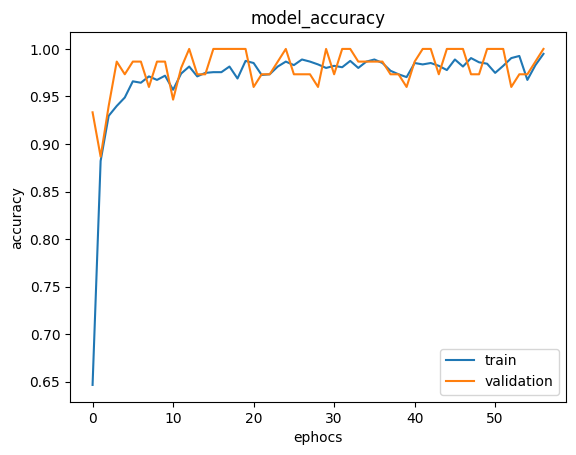

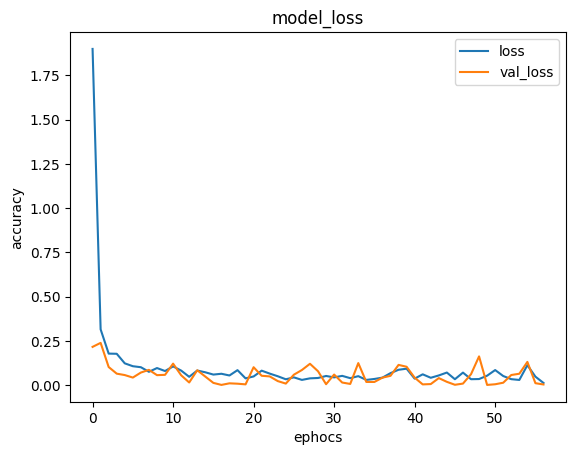

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.legend(['loss', 'val_loss'])
plt.show()

In [36]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  output = model.predict(images)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

Saving wayang_cepot_292.jpg to wayang_cepot_292 (1).jpg
1/1 [==============================] - 0s 26ms/step
wayang_cepot_292 (1).jpg
[[1.4506118e-17 1.0000000e+00 1.1661374e-17 2.9799566e-20 3.8265992e-22]]
cepot


In [37]:
# os.listdir(train_dir)

In [38]:
!mkdir -p saved_model_h5
model.save('saved_model_h5/model_tl_inception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from keras.preprocessing import image

# img_path = '/content/images/images/test/wayang_bagong_(7).jpg'
# img = image.load_img(img_path, target_size=(300,300))
# x = image.img_to_array(img) / .255
# x = np.expand_dims(x, axis=0)
# images = np.vstack([x])

# print(x.shape)

# classes = ['semar', 'gareng', 'petruk', 'cepot', 'bagong']

# output = model.predict(images)
# best_index = np.argmax(output)
# print(output)
# print(classes[best_index])

In [ ]:
# from keras.models import load_model
# import cv2
# import numpy as np
# from keras.preprocessing import image
# from google.colab.patches import cv2_imshow
# from PIL import Image

# classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']


# image_testing = Image.open('/content/images/images/test/wayang_semar_10 - Copy.jpg')
# image_testing = np.array(image_testing.resize((300, 300))) / 255.0
# image_testing.shape

# image_testing = np.expand_dims(image_testing, axis=0)
# print(image_testing.shape)

# output = model.predict(image_testing)
# best_index = np.argmax(output)
# class_name = classes[best_index]

# print(output)
# print(best_index)
# print(class_name)

In [ ]:
# from tensorflow.keras.applications import ResNet152V2

# model = tf.keras.Sequential([
#     ResNet152V2(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(300,300,3)
#     ),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model.layers[0].trainable=False

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy'])

In [ ]:
# history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks=[callback])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model_accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('ephocs')
# plt.legend(['train', 'validation'])
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model_loss')
# plt.ylabel('accuracy')
# plt.xlabel('ephocs')
# plt.legend(['loss', 'val_loss'])
# plt.show()

In [ ]:
# !mkdir -p saved_model_h5
# model.save('saved_model_h5/model_tl.h5')

In [ ]:
# from keras.preprocessing import image

# img_path = '/content/images/test/wayang_semar_2.jpg'
# img = image.load_img(img_path, target_size=(150,150))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)

# classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']

# output = model.predict(x)
# best_index = np.argmax(output)
# print(classes[best_index])

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3,3), input_shape=(300,300,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
# history = model.fit(train_generator, epochs=20, steps_per_epoch=27, validation_data=valid_generator, validation_steps=3)

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']


# plt.plot(acc)
# plt.plot(val_acc)

# plt.show()

In [ ]:
# model2 = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model2.summary()

In [ ]:
# model2.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
# history2 = model2.fit(train_generator, epochs=50, steps_per_epoch=27, validation_data=valid_generator, validation_steps=3)

In [ ]:
# acc = history2.history['accuracy']
# val_acc = history2.history['val_accuracy']


# plt.plot(acc)
# plt.plot(val_acc)

# plt.show()

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    vertical_flip=True)

# valid_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(300,300),
#                                                     batch_size=32,
#                                                     class_mode = 'categorical')

# valid_generator = valid_datagen.flow_from_directory(val_dir,
#                                                     target_size=(300,300),
#                                                     batch_size=32,
#                                                     class_mode='categorical')

In [ ]:
# history3 = model2.fit(train_generator, epochs=50, validation_data=valid_generator)

In [ ]:
# acc = history3.history['accuracy']
# val_acc = history3.history['val_accuracy']


# plt.plot(acc)
# plt.plot(val_acc)

# plt.show()

In [ ]:
# model3 = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

In [ ]:
# !mkdir -p saved_model_h5
# model2.save('saved_model_h5/FirstModel.h5')

In [ ]:
# model3.compile(loss='categorical_crossentropy',
#                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#                metrics=['accuracy'])

# history = model3.fit(train_generator, epochs=30, validation_data=valid_generator)

In [ ]:
# tfjs.converters.save_keras_model(model2, "/content/")

In [ ]:
  # from tensorflow.keras.utils import load_img, img_to_array

  # img = load_img('/content/images/test/wayang_bagong_(2).jpg', target_size=(300, 300))
  # x = img_to_array(img)
  # x = np.expand_dims(x, axis=0)

  # images = np.vstack([x])
  # classes = model2.predict(images)

  # print(classes)

In [ ]:
# from keras.models import load_model

# loaded_model = load_model('/content/saved_model_h5/FirstModel.h5')